In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import joblib

In [3]:
data2 = pd.read_csv("filename.csv")

[0]	validation_0-rmse:17059.78165	validation_0-mae:13957.87125	validation_1-rmse:17041.29764	validation_1-mae:13940.53780
[1]	validation_0-rmse:15486.11635	validation_0-mae:12661.57399	validation_1-rmse:15469.98631	validation_1-mae:12647.16486
[2]	validation_0-rmse:14000.38026	validation_0-mae:11444.32495	validation_1-rmse:13984.82488	validation_1-mae:11431.08980
[3]	validation_0-rmse:12663.22345	validation_0-mae:10346.75388	validation_1-rmse:12649.40156	validation_1-mae:10336.71209
[4]	validation_0-rmse:11513.24637	validation_0-mae:9400.42495	validation_1-rmse:11500.34567	validation_1-mae:9391.23245
[5]	validation_0-rmse:10416.41008	validation_0-mae:8503.19332	validation_1-rmse:10404.28641	validation_1-mae:8495.26282
[6]	validation_0-rmse:9424.85493	validation_0-mae:7689.23710	validation_1-rmse:9415.83775	validation_1-mae:7684.74526
[7]	validation_0-rmse:8529.79128	validation_0-mae:6959.14533	validation_1-rmse:8520.86777	validation_1-mae:6955.23518
[8]	validation_0-rmse:7719.37920	val

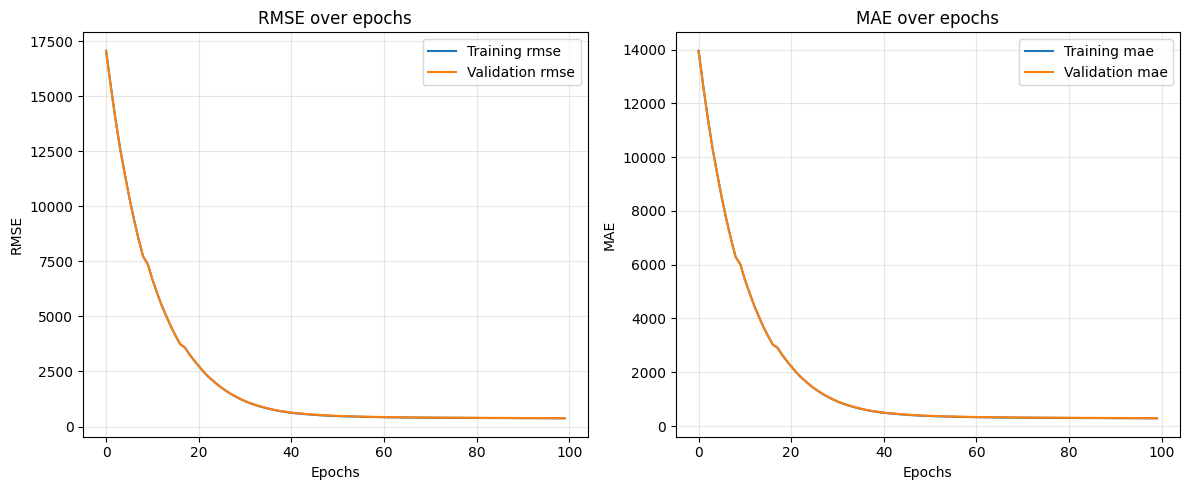

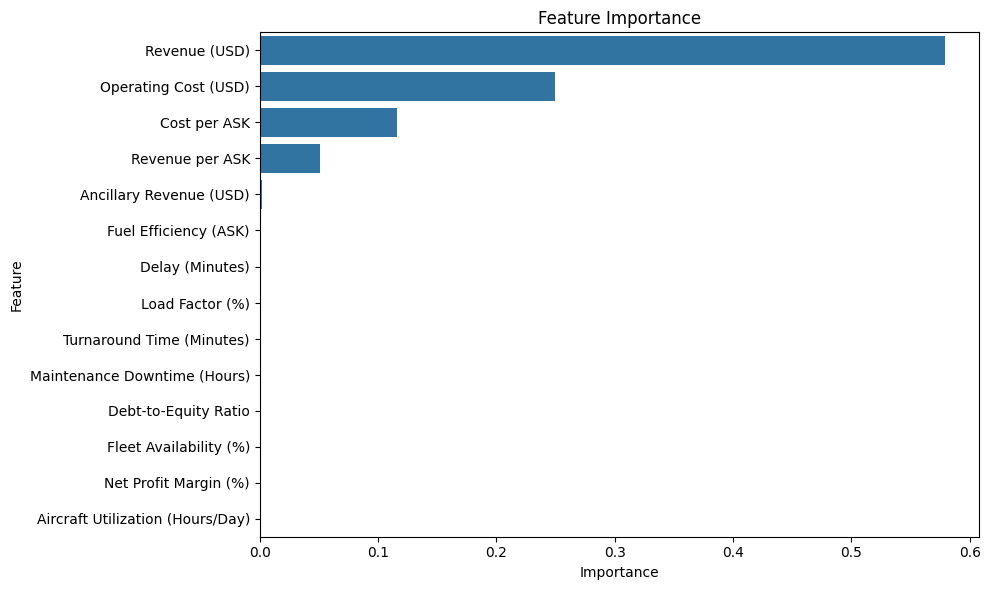

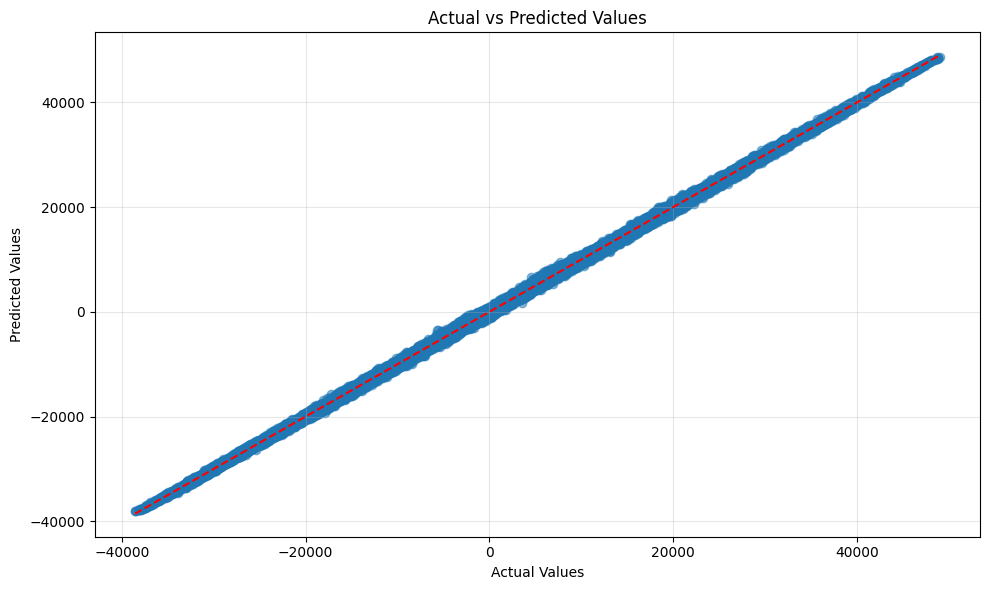

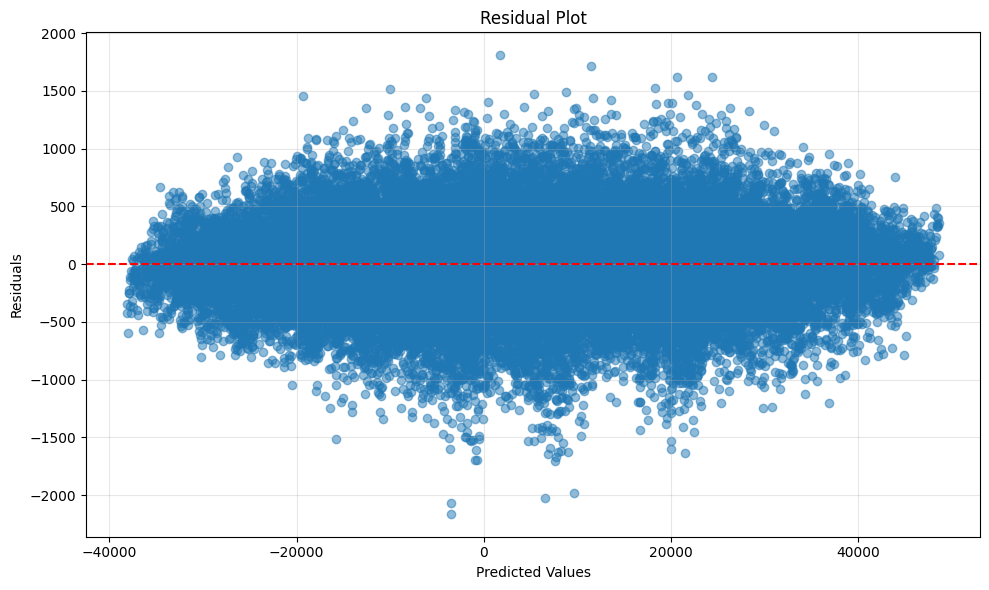

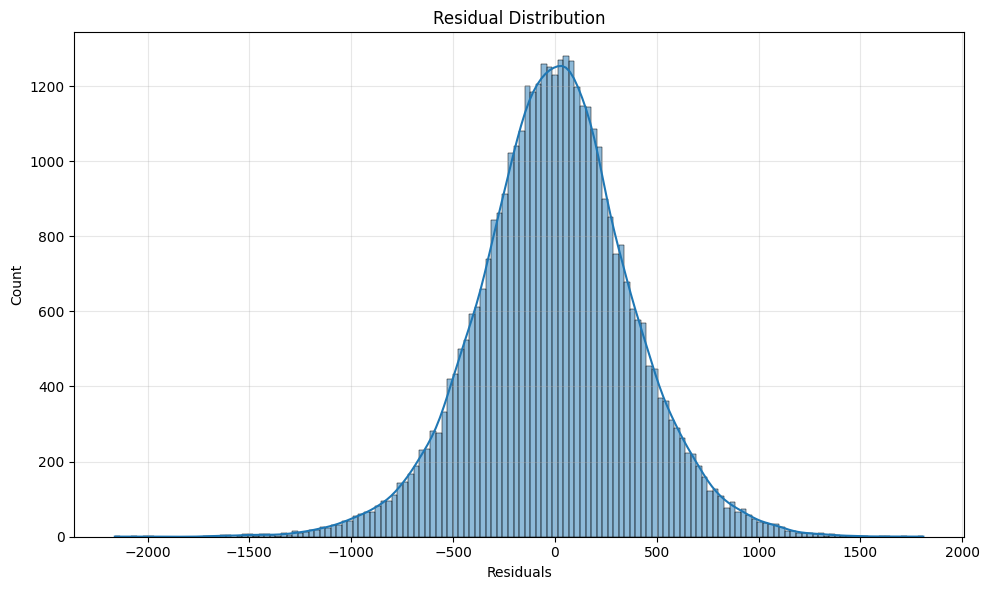

Optimized model saved as 'xgb_price_predictor_optimized.pkl'


In [4]:
import warnings
warnings.filterwarnings('ignore')

class XGBPricePredictor:
    def __init__(self, params=None):
        """
        Initialize the XGBRegressor model with default or custom parameters.
        
        Parameters:
        -----------
        params : dict, optional
            Dictionary of parameters to initialize the XGBRegressor model.
        """
        # Default parameters if none provided
        self.default_params = {
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 5,
            'min_child_weight': 1,
            'gamma': 0,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'objective': 'reg:squarederror',
            'random_state': 42
        }
        
        self.params = params if params is not None else self.default_params
        self.model = XGBRegressor(**self.params)
        self.history = {'train': {}, 'val': {}}
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, verbose=True, early_stopping_rounds=None):
        """
        Fit the model to the training data and track metrics per epoch.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training target values
        X_val : array-like, optional
            Validation features
        y_val : array-like, optional
            Validation target values
        verbose : bool, default=True
            Whether to print progress information
        early_stopping_rounds : int, optional
            Activates early stopping if validation score doesn't improve for this many rounds
        
        Returns:
        --------
        self : object
            Fitted model
        """
        # Set metrics directly in the model parameters
        self.model.set_params(eval_metric=['rmse', 'mae'])
        
        # Prepare evaluation set
        eval_set = [(X_train, y_train)]
        eval_metric_names = ['rmse', 'mae']
        eval_names = ['train']
        
        if X_val is not None and y_val is not None:
            eval_set.append((X_val, y_val))
            eval_names.append('val')
        
        # For scikit-learn API, use different approach based on your XGBoost version
        try:
            # For newer versions try this approach first
            if early_stopping_rounds is not None:
                self.model.set_params(early_stopping_rounds=early_stopping_rounds)
            
            self.model.fit(
                X_train, y_train,
                eval_set=eval_set,
                verbose=verbose
            )
        except TypeError:
            # For older versions, try the direct parameters approach
            kwargs = {
                'eval_set': eval_set,
                'verbose': verbose
            }
            if early_stopping_rounds is not None:
                kwargs['early_stopping_rounds'] = early_stopping_rounds
            
            try:
                self.model.fit(X_train, y_train, **kwargs)
            except TypeError:
                # Final fallback - just do a basic fit
                print("Warning: Could not use evaluation sets with this XGBoost version. Using basic fit.")
                self.model.fit(X_train, y_train)
                
        # Try to extract results if available
        try:
            eval_results = self.model.evals_result()
            
            # Convert to our history format
            for i, name in enumerate(eval_names):
                eval_key = f"validation_{i}" if i > 0 else "validation_0"
                if eval_key in eval_results:
                    for metric, values in eval_results[eval_key].items():
                        if name not in self.history:
                            self.history[name] = {}
                        if metric not in self.history[name]:
                            self.history[name][metric] = []
                        self.history[name][metric] = values
        except:
            # If evals_result() is not available, create basic metrics manually
            print("Warning: Could not retrieve evaluation history. Metrics tracking may be limited.")
            y_pred_train = self.predict(X_train)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            mae_train = mean_absolute_error(y_train, y_pred_train)
            
            self.history['train']['rmse'] = [rmse_train]
            self.history['train']['mae'] = [mae_train]
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
                mae_val = mean_absolute_error(y_val, y_pred_val)
                
                self.history['val'] = {}
                self.history['val']['rmse'] = [rmse_val]
                self.history['val']['mae'] = [mae_val]
        
        return self
    
    def predict(self, X):
        """
        Make predictions with the trained model.
        
        Parameters:
        -----------
        X : array-like
            Features for prediction
        
        Returns:
        --------
        array-like
            Predicted values
        """
        return self.model.predict(X)
    
    def evaluate(self, X, y_true):
        """
        Evaluate the model performance on given data.
        
        Parameters:
        -----------
        X : array-like
            Features for prediction
        y_true : array-like
            True target values
        
        Returns:
        --------
        dict
            Dictionary containing various evaluation metrics
        """
        y_pred = self.predict(X)
        
        metrics = {
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred),
            'mape': mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
        }
        
        return metrics
    
    def tune_hyperparameters(self, X_train, y_train, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1):
        """
        Perform grid search to find the best hyperparameters.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training target values
        param_grid : dict
            Dictionary with parameters names as keys and lists of parameter settings to try
        cv : int, default=5
            Number of cross-validation folds
        scoring : str, default='neg_mean_squared_error'
            Scoring metric for evaluation
        verbose : int, default=1
            Controls verbosity of the grid search
        
        Returns:
        --------
        dict
            Best parameters found
        """
        grid_search = GridSearchCV(
            XGBRegressor(),
            param_grid,
            cv=cv,
            scoring=scoring,
            verbose=verbose,
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        self.params = grid_search.best_params_
        self.model = XGBRegressor(**self.params)
        
        print(f"Best parameters found: {grid_search.best_params_}")
        print(f"Best score: {grid_search.best_score_:.4f}")
        
        return grid_search.best_params_
    
    def plot_training_history(self, figsize=(12, 5)):
        """
        Plot the training and validation metrics over epochs.
        
        Parameters:
        -----------
        figsize : tuple, default=(12, 5)
            Figure size
        """
        if not self.history['train']:
            print("No training history available. Please train the model first.")
            return
            
        # Determine how many metrics we have
        metrics = list(self.history['train'].keys())
        n_metrics = len(metrics)
        
        if n_metrics == 0:
            print("No metrics found in training history.")
            return
        
        # Create the appropriate number of subplots
        if n_metrics == 1:
            fig, ax = plt.subplots(figsize=figsize)
            axes = [ax]
        else:
            fig, axes = plt.subplots(1, n_metrics, figsize=figsize)
            if n_metrics == 2:
                axes = list(axes)  # Ensure axes is a list for indexing
        
        for i, metric in enumerate(metrics):
            ax = axes[i] if n_metrics > 1 else axes
            
            # Plot training metric
            ax.plot(self.history['train'][metric], label=f'Training {metric}')
            
            # Plot validation metric if available
            if 'val' in self.history and metric in self.history['val']:
                ax.plot(self.history['val'][metric], label=f'Validation {metric}')
            
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric.upper())
            ax.set_title(f'{metric.upper()} over epochs')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance(self, feature_names=None, figsize=(10, 6), top_n=None):
        """
        Plot feature importance of the trained model.
        
        Parameters:
        -----------
        feature_names : list, optional
            Names of features
        figsize : tuple, default=(10, 6)
            Figure size
        top_n : int, optional
            Number of top features to show
        """
        importances = self.model.feature_importances_
        
        if feature_names is None:
            feature_names = [f'Feature {i}' for i in range(len(importances))]
        
        # Create a DataFrame for easier sorting and plotting
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        if top_n is not None:
            importance_df = importance_df.head(top_n)
        
        plt.figure(figsize=figsize)
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    
    def plot_predictions(self, X, y_true, figsize=(10, 6)):
        """
        Plot actual vs predicted values.
        
        Parameters:
        -----------
        X : array-like
            Features for prediction
        y_true : array-like
            True target values
        figsize : tuple, default=(10, 6)
            Figure size
        """
        y_pred = self.predict(X)
        
        plt.figure(figsize=figsize)
        plt.scatter(y_true, y_pred, alpha=0.5)
        
        # Plot the perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted Values')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def get_residuals_plot(self, X, y_true, figsize=(10, 6)):
        """
        Plot residuals to check for patterns.
        
        Parameters:
        -----------
        X : array-like
            Features for prediction
        y_true : array-like
            True target values
        figsize : tuple, default=(10, 6)
            Figure size
        """
        y_pred = self.predict(X)
        residuals = y_true - y_pred
        
        plt.figure(figsize=figsize)
        
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Also show residual distribution
        plt.figure(figsize=figsize)
        sns.histplot(residuals, kde=True)
        plt.xlabel('Residuals')
        plt.title('Residual Distribution')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


# Example usage:
if __name__ == "__main__":
    X = data2.drop(["Profit (USD)", "Flight Number", "Scheduled_Year", "Scheduled_Weekday", "Scheduled_Month"], axis = 1)
    y = data2["Profit (USD)"]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Initialize and train model with default parameters
    xgb_model = XGBPricePredictor()
    xgb_model.fit(X_train, y_train, X_val=X_val, y_val=y_val)
    
    # Evaluate model
    train_metrics = xgb_model.evaluate(X_train, y_train)
    test_metrics = xgb_model.evaluate(X_test, y_test)
    
    print("Training metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nTest metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot training history
    xgb_model.plot_training_history()
    
    # Plot feature importance
    xgb_model.plot_feature_importance(feature_names=X.columns)
    
    # Plot predictions
    xgb_model.plot_predictions(X_test, y_test)
    
    # Plot residuals
    xgb_model.get_residuals_plot(X_test, y_test)
    
    # Example of hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1]
    }

    joblib.dump(xgb_model, 'xgb_price_predictor_optimized.pkl')
    print("Optimized model saved as 'xgb_price_predictor_optimized.pkl'")
    
    # Uncomment to run hyperparameter tuning (can be time-consuming)
    #best_params = xgb_model.tune_hyperparameters(X_train, y_train, param_grid, cv=3)

In [5]:
xgb_model = XGBPricePredictor()
xgb_model.fit(X_train, y_train)
array = np.array([[50,12.36,115,79.18,96.24,9.21,4.15,10953.75,27847.59,17.90,1058.68,2.46,2639.46,6710.26]])
prediction = xgb_model.predict(array)

[0]	validation_0-rmse:17059.78165	validation_0-mae:13957.87125
[1]	validation_0-rmse:15486.11635	validation_0-mae:12661.57399
[2]	validation_0-rmse:14000.38026	validation_0-mae:11444.32495
[3]	validation_0-rmse:12663.22345	validation_0-mae:10346.75388
[4]	validation_0-rmse:11513.24637	validation_0-mae:9400.42495
[5]	validation_0-rmse:10416.41008	validation_0-mae:8503.19332
[6]	validation_0-rmse:9424.85493	validation_0-mae:7689.23710
[7]	validation_0-rmse:8529.79128	validation_0-mae:6959.14533
[8]	validation_0-rmse:7719.37920	validation_0-mae:6288.46192
[9]	validation_0-rmse:7374.91024	validation_0-mae:6021.42965
[10]	validation_0-rmse:6676.30651	validation_0-mae:5450.50692
[11]	validation_0-rmse:6077.47721	validation_0-mae:4951.92013
[12]	validation_0-rmse:5503.60085	validation_0-mae:4482.63221
[13]	validation_0-rmse:5014.88953	validation_0-mae:4077.48885
[14]	validation_0-rmse:4544.95557	validation_0-mae:3691.15556
[15]	validation_0-rmse:4121.98049	validation_0-mae:3346.43226
[16]	val